In [1]:
import numpy as np
import cvxpy as cp
import scipy as sp
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from warnings import filterwarnings
filterwarnings('ignore', category=np.ComplexWarning)

## Simulation Parameters

In [2]:
dt = 0.04  # timestep
t = 1  # duration
m = 1  # mass
q0 = np.array([0, 0])  # init pos
v0 = np.array([2, 2])  # init vel
force = np.array([0, 30])  # init force
g = 9.8  # gravitational acceleration
mu = 0.05  # coefficient of friction of the plane

## Simulation Backend

In [3]:
class SimSystem:
    def __init__(self, q0, v0):
        self.q = q0
        self.v = v0
    
    def step_q(self, update=True):
        """ Find next q according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
        
    def step_v(self, update=True):
        """ Find next v according to system dynamics. Store if UPDATE. """
        raise NotImplementedError()
    
    def plot(self, q=None):
        """
        Generate a plot for current config (or for Q if specified)
        """
        raise NotImplementedError()
    
    @property
    def dim(self):
        return self.q.shape[0]
        

In [4]:
class Block2D(SimSystem):
    def __init__(self, pos, vel, mass, force,
                 dt=0.1, mu=0.3, solver='ECOS'):
        super().__init__(pos, vel)
        self.m = mass
        self.f = force
        self.dt = dt
        self.mu = mu
        self.solver = solver
    
    def step_q(self, update=True):
        q_new = self.q + self.dt * self.v
        if update:
            self.q = q_new
        return q_new
    
    def step_v(self, update=True):
        b = self.get_b()
        v_new = self.v + (b + self.dt * self.f) / self.m
        if update:
            self.v = v_new
        return v_new
    
    def get_b(self):
        """
        b = argmin(v^\top v) s.t. b^\top b <= (\mu * m * g)^2. set to self.b for debugging purposes.
        """
        if self.solver in ['eig0', 'eig1']:
            self.b = self.get_b_eig()
        else:
            b = cp.Variable(self.dim)
            constraints = [cp.SOC(self.mu * self.m * g, b)]
            z = b + self.dt * self.f
            prob = cp.Problem(cp.Minimize(cp.norm(z, 2)**2 + 2 * self.m * (z @ self.v)),
                              constraints)
            prob.solve(solver=self.solver)
            self.b = b.value
        return self.b
    
    def get_b_eig(self):
        alpha = 1  # "an arbitrary alpha > 0 (p. 10)"
        """ Interior case """
        b0 = -self.f * self.dt - self.m * self.v
        """ Boundary case """
        # set up generalized eigenvalue problem
        expr = (self.f * self.dt + self.m * self.v).reshape(self.dim, 1)
        delta = self.mu * self.m * g
        if self.solver == 'eig0':
            A = -np.block([
                [delta**2, np.zeros((1, self.dim)), expr.T],
                [np.zeros((self.dim, 1)), -np.eye(self.dim), np.eye(self.dim)],
                [expr, np.eye(self.dim), np.zeros((self.dim, self.dim))]
            ]).astype(np.float64)
            B = -np.block([
                [np.zeros((1, 1 + 2*self.dim))],
                [np.zeros((self.dim, 1 + self.dim)), -np.eye(self.dim)],
                [np.zeros((self.dim, 1)), -np.eye(self.dim), np.zeros((self.dim, self.dim))]
            ]).astype(np.float64)
            split_idx = [1, 1 + self.dim]
            sorted_largest_eig_idx = -2  # skip inf eigval
        elif self.solver == 'eig1':
            A = np.block([
                [np.eye(self.dim), -np.eye(self.dim)],
                [-np.eye(self.dim), (expr @ expr.T) / (delta**2)]
            ]).astype(np.float64)
            B = np.block([
                [np.zeros((self.dim, self.dim)), np.eye(self.dim)],
                [np.eye(self.dim), np.zeros((self.dim, self.dim))]
            ]).astype(np.float64)
            split_idx = [0, self.dim]
            sorted_largest_eig_idx = -1  # only finite eigvals
        else:
            raise ValueError('This function is for solvers eig0 or eig1, specifying the matrix pencil used.')
        # solve the generalized eigenvalue problem
        eigvals, V = sp.linalg.eig(A, B)
        sorted_eigvals = np.argsort(eigvals)
        largest_eig_idx = sorted_eigvals[sorted_largest_eig_idx]
        second_largest_eig_idx = sorted_eigvals[sorted_largest_eig_idx-1]
        V1 = V[:, largest_eig_idx]
        gap = eigvals[largest_eig_idx] - eigvals[largest_eig_idx-1]
        _, y1, y2 = np.split(V1, split_idx)
        
        # 10**-8 const from the paper, eq 4.5
        if gap == 0 or np.linalg.norm(y1) <= 10**-8 / np.sqrt(gap):
            print('HARD CASE')
            # "hard case" (§4.1 of paper)
            V_large = V[:, eigvals == eigvals[largest_eig_idx]]
            H = (1 + eigvals[largest_eig_idx]) * np.eye(self.dim) + alpha * V_large @ V_large.T
            q = -np.linalg.inv(H) @ expr
            b1 = q + (delta**2 - V1 @ V1 - q @ q) / (2 * q @ V1) * V1
        else:
            b1 = -np.sign(y2 @ expr) * delta * y1 / np.linalg.norm(y1)
        # having found b0 and b1, pick the one with lower objective value
        objective = lambda arr: arr @ arr + 2 * (arr @ expr)
        b = b0 if (objective(b0) < objective(b1)) and (np.linalg.norm(b0) < delta) else b1
        return b
    
    def plot(self, q=None):
        if q is None:
            q = self.q
        fig = plt.figure()
        canvas = FigureCanvas(fig)
        plt.xlim(-8, 8)
        plt.ylim(-8, 8)
        plt.plot(q[0], q[1], 'ro')
        canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close()
        return img

## Run Simulation

In [5]:
def sim(system, timesteps=10, plot=False, return_bs=False):
    """
    :param system: (SimSystem) initialized obj representing system,
                    including functions to update q and v
    :param timesteps: (int) number of timesteps to simulate for
    """
    qs, vs = [system.q.copy()], [system.v.copy()]
    if plot:
        plots = [system.plot()]
    if return_bs:
        bs = []
    t = 0
    while t < timesteps:
        qs.append(system.step_q().copy())
        vs.append(system.step_v().copy())
        # print(system.q)
        if plot:
            plots.append(system.plot())
        if return_bs:
            bs.append(system.b)
        t += system.dt
    retval = [qs]
    if plot:
        retval.append(plots)
    if return_bs:
        retval.append(bs)
    return retval

In [6]:
system = Block2D(q0, v0, m, force, dt, mu, solver='ECOS')
qs, plots, bs = sim(system, timesteps=2, plot=True, return_bs=True)

In [7]:
system = Block2D(q0, v0, m, force, dt, mu, solver='eig0')
qs_eig, plots_eig, bs_eig = sim(system, timesteps=2, plot=True, return_bs=True)

In [8]:
np.allclose(plots_eig, plots)

True

## Plot

In [9]:
time = datetime.now().strftime('%m%d%y_%H%M%S')
filename = f'gifs/sim2d_{time}.gif'
imageio.mimwrite(filename, plots, fps=int(1/dt));

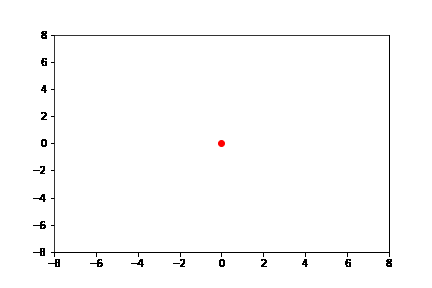

In [10]:
from IPython.display import Image
Image(filename=filename)